# Problem 1

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
device = torch.device('mps')
# Data Preprocessing
def preprocess_data():
    transform = T.Compose([T.ToTensor(), T.Resize((8, 8)), T.Normalize((0.5,), (0.5,))])
    train_data = MNIST(root='./data', train=True, download=True, transform=transform)
    test_data = MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)
    return train_loader, test_loader

class RealNVP(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, num_layers=4):
        super(RealNVP, self).__init__()
        self.num_layers = num_layers
        self.coupling_layers = nn.ModuleList([CouplingLayer(input_dim, hidden_dim) for _ in range(num_layers)])

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.coupling_layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.inverse(z)
        return z

class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CouplingLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim // 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim // 2)
        self.fc3 = nn.Linear(hidden_dim, input_dim // 2)  

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        h = torch.relu(self.fc1(x1))
        s = self.fc2(h)
        t = self.fc3(h)
        z2 = x2 * torch.exp(s) + t
        return torch.cat((x1, z2), dim=1), torch.sum(s, dim=1)  # log-det jacobian

    def inverse(self, z):
        z1, z2 = torch.chunk(z, 2, dim=1)
        h = torch.relu(self.fc1(z1))
        s = self.fc2(h)
        t = self.fc3(h)
        x2 = (z2 - t) / torch.exp(s)
        return torch.cat((z1, x2), dim=1)

class MAF(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, num_layers=4):
        super(MAF, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList([MaskedAutoregressiveLayer(input_dim, hidden_dim) for _ in range(num_layers)])

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

class MaskedAutoregressiveLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MaskedAutoregressiveLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.mask = self.create_mask(input_dim).to(device)  # Create and move mask to device

    def forward(self, x):
        # Apply the mask to the input
        # Change here to apply mask to each row of x
        x_masked = x * self.mask  
        h = torch.relu(self.fc1(x_masked))
        out = torch.sigmoid(self.fc2(h))
        log_det_jacobian = torch.sum(torch.log(out), dim=1)
        return out, log_det_jacobian

    def inverse(self, z):
        # Apply the mask to the input
        # Change here to apply mask to each row of x
        z_masked = z * self.mask  
        h = torch.relu(self.fc1(z_masked))
        out = torch.sigmoid(self.fc2(h))
        return out

    def create_mask(self, dim):
        # Create a lower triangular mask with ones on the diagonal and below
        mask = torch.tril(torch.ones(dim, dim))  # Create a lower triangular 2D matrix
        mask = mask[:, -1]  # Select the last column to get a (dim,) vector
        mask = mask.unsqueeze(0)  # Reshape to (1, dim) for broadcasting
        return mask.to(device)



def train_model(model, train_loader, epochs=10, lr=1e-3):
    model.to(device)  # Move model to MPS device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Use MSE loss or log-likelihood for training
    
    for epoch in range(epochs):
        model.train()
        for data, _ in train_loader:
            data = data.to(device)  # Move data to MPS device
            data = data.view(data.size(0), -1)  # Flatten the images
            optimizer.zero_grad()
            output, _ = model(data)  # Unpack the output tuple 
            loss = criterion(output, data)  # Minimize the reconstruction error
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Sampling from the model (for generating synthetic images)
def sample_images(model, num_samples=64):
    model.eval()
    model.to(device)  # Move model to MPS device
    with torch.no_grad():
        z = torch.randn(num_samples, 64).to(device)  # Latent space sampling
        generated_images = model.inverse(z)
        generated_images = generated_images.view(num_samples, 1, 8, 8)
        return generated_images



# Log-likelihood evaluation (simplified example)
def evaluate_log_likelihood(model, test_loader):
    model.eval()
    total_ll = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            _, log_prob = model(data)
            total_ll += log_prob.sum().item()
    avg_ll = total_ll / len(test_loader.dataset)
    return avg_ll

# Visualize generated images in grid
def plot_generated_images(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(images[i*8+j].squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.show()







Epoch 1/10, Loss: 7.120594091247767e-05
Epoch 2/10, Loss: 2.4674951419001445e-05
Epoch 3/10, Loss: 1.5418243492604233e-05
Epoch 4/10, Loss: 2.1946099877823144e-05
Epoch 5/10, Loss: 1.1764443115680479e-05
Epoch 6/10, Loss: 1.3201871297496837e-05
Epoch 7/10, Loss: 1.942621383932419e-05
Epoch 8/10, Loss: 9.205159585690126e-06
Epoch 9/10, Loss: 6.148983629827853e-06
Epoch 10/10, Loss: 8.826948032947257e-06


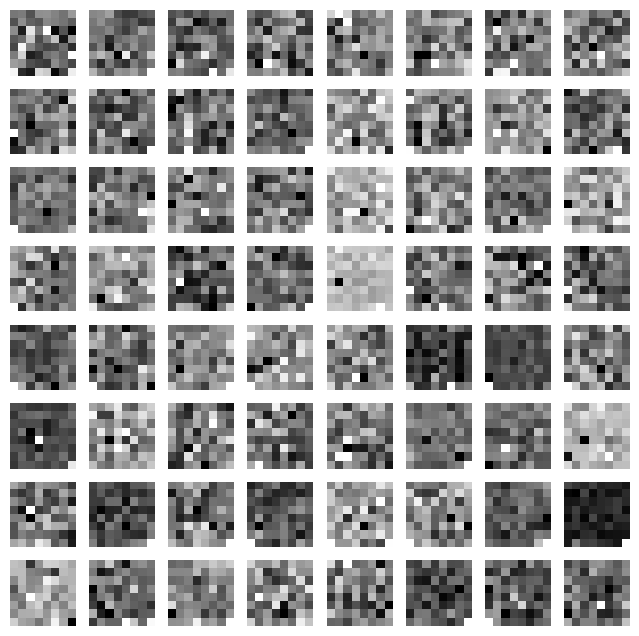

-2.3840173583984376


In [20]:
train_loader, test_loader = preprocess_data()
realnvp_model = RealNVP(input_dim=64).to(device)
train_model(realnvp_model, train_loader)
realnvp_images = sample_images(realnvp_model)
plot_generated_images(realnvp_images.cpu()) 
print(evaluate_log_likelihood(realnvp_model,test_loader))

Epoch 1/10, Loss: 0.7374919652938843
Epoch 2/10, Loss: 0.7196009159088135
Epoch 3/10, Loss: 0.719971776008606
Epoch 4/10, Loss: 0.7147953510284424
Epoch 5/10, Loss: 0.718071699142456
Epoch 6/10, Loss: 0.7165360450744629
Epoch 7/10, Loss: 0.717714786529541
Epoch 8/10, Loss: 0.7192978858947754
Epoch 9/10, Loss: 0.7230333089828491
Epoch 10/10, Loss: 0.722332239151001


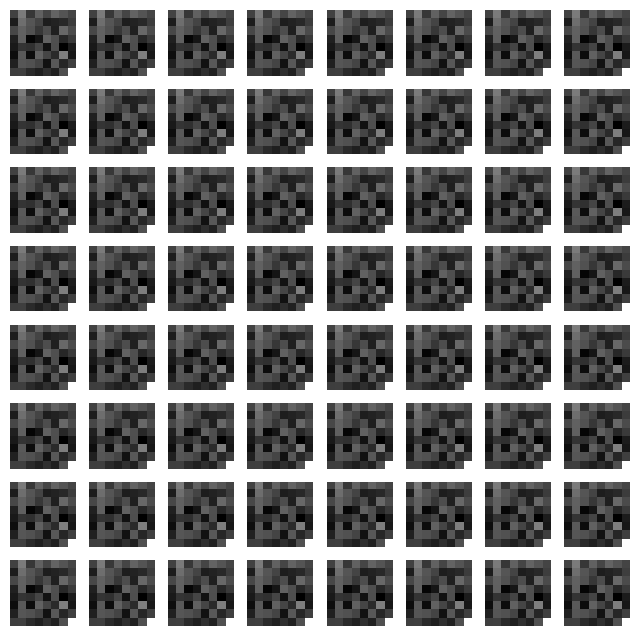

-1125.45725


In [21]:
maf_model = MAF(input_dim=64).to(device)
train_model(maf_model, train_loader)
maf_images = sample_images(maf_model)
plot_generated_images(maf_images.cpu())
print(evaluate_log_likelihood(maf_model,test_loader))

# Problem 2

Epoch [1/10], Loss: 4.9938
Epoch [2/10], Loss: 0.9572
Epoch [3/10], Loss: 1.6116
Epoch [4/10], Loss: 1.7606
Epoch [5/10], Loss: 7.8659
Epoch [6/10], Loss: 1.1840
Epoch [7/10], Loss: 57.9632
Epoch [8/10], Loss: 0.7101
Epoch [9/10], Loss: 8.2169
Epoch [10/10], Loss: 0.5193


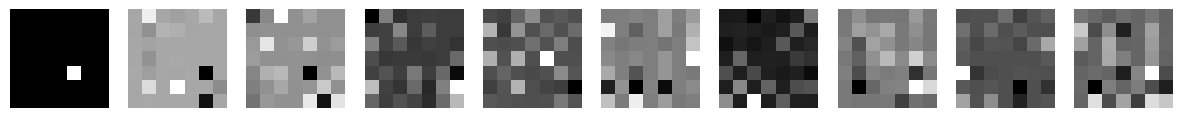

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('mps')

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((7, 7)),
    transforms.Grayscale(num_output_channels=1),  # Ensure the images are single-channel
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# WaveNet-like model with improvements
class WaveNet2DImproved(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_layers=4, num_filters=128, kernel_size=3, dropout_rate=0.5):
        super(WaveNet2DImproved, self).__init__()
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.layers = nn.ModuleList()
        self.skip_connections = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        self.output_conv = nn.Conv2d(num_filters, out_channels, kernel_size=1)
        
        for i in range(num_layers):
            dilation = 2 ** i
            self.layers.append(
                nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, dilation=dilation, padding=dilation)
            )
            self.skip_connections.append(
                nn.Conv2d(num_filters, num_filters, kernel_size=1)
            )
            in_channels = num_filters

        self.output_conv = nn.Conv2d(num_filters, out_channels, kernel_size=1)

    def forward(self, x):
        skip_sum = 0
        for i in range(self.num_layers):
            residual = x
            x = F.relu(self.layers[i](x))
            x = self.dropout(x)  # Apply dropout after each layer
            skip_sum += self.skip_connections[i](x)
            x = x + residual  # Residual connection
        return self.output_conv(skip_sum)  # Combine the skip connections

# Weight initialization (Xavier initialization for convolutions)
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Instantiate the model and apply weight initialization
model = WaveNet2DImproved().to(device)
model.apply(init_weights)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

# Gradient clipping to avoid exploding gradients
def train(model, train_loader, optimizer, criterion, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Training the model
train(model, train_loader, optimizer, criterion, num_epochs=10)

# Image generation function
def generate_images(model, num_images=20):
    model.eval()
    with torch.no_grad():
        generated_images = []
        for _ in range(num_images):
            z = torch.randn(1, 1, 7, 7).to(device)  # Move z to the correct device
            generated_img = model(z)
            generated_images.append(generated_img.squeeze(0).squeeze(0).cpu().numpy())  # Move output back to CPU for plotting
        return generated_images

# Generate synthetic images
generated_images = generate_images(model)

# Plotting function
def plot_images(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Plot generated images
plot_images(generated_images)


Epoch [1/25], Loss: 0.1819
Epoch [2/25], Loss: 0.1633
Epoch [3/25], Loss: 0.1625
Epoch [4/25], Loss: 0.1621
Epoch [5/25], Loss: 0.1617
Epoch [6/25], Loss: 0.1615
Epoch [7/25], Loss: 0.1613
Epoch [8/25], Loss: 0.1611
Epoch [9/25], Loss: 0.1610
Epoch [10/25], Loss: 0.1609
Epoch [11/25], Loss: 0.1609
Epoch [12/25], Loss: 0.1608
Epoch [13/25], Loss: 0.1607
Epoch [14/25], Loss: 0.1607
Epoch [15/25], Loss: 0.1606
Epoch [16/25], Loss: 0.1606
Epoch [17/25], Loss: 0.1605
Epoch [18/25], Loss: 0.1605
Epoch [19/25], Loss: 0.1605
Epoch [20/25], Loss: 0.1604
Epoch [21/25], Loss: 0.1604
Epoch [22/25], Loss: 0.1604
Epoch [23/25], Loss: 0.1603
Epoch [24/25], Loss: 0.1603
Epoch [25/25], Loss: 0.1603


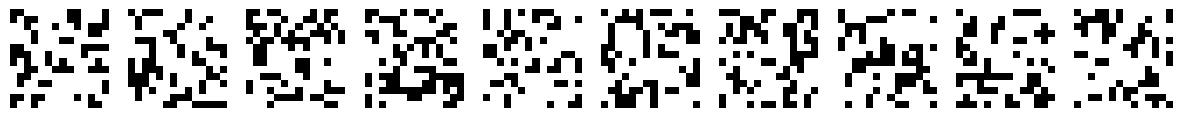

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("mps")

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((7, 7)),  # Try larger image sizes
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------
# PixelCNN Model
# ----------------------
class MaskedConv2d(nn.Conv2d):
    """ Masked Convolution for Autoregressive Image Generation """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer("mask", torch.ones_like(self.weight))
        
        _, _, h, w = self.weight.shape
        self.mask[:, :, h//2, w//2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h//2 + 1:] = 0  # Ensure dependency only on previous pixels

    def forward(self, x):
        self.weight.data *= self.mask  # Apply mask at runtime
        return super().forward(x)

class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=128, num_layers=4):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # First layer - Mask type 'A' (ensures pixels do not depend on themselves)
        self.layers.append(MaskedConv2d(input_channels, hidden_dim, kernel_size=7, mask_type='A', padding=3))
        
        # Hidden layers - Mask type 'B' (allows dependencies on previous pixels)
        for _ in range(num_layers - 2):
            self.layers.append(MaskedConv2d(hidden_dim, hidden_dim, kernel_size=3, mask_type='B', padding=1))
            self.layers.append(nn.ReLU())
        
        # Output layer
        self.layers.append(MaskedConv2d(hidden_dim, input_channels, kernel_size=1, mask_type='B'))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)  # Convert logits to probability (for binary pixels)

# Instantiate model
model = PixelCNN().to(device)

# ----------------------
# Training Setup
# ----------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()  # Binary Cross-Entropy for probabilistic pixel generation

def train(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, (images + 1) / 2)  # Convert to [0,1] for BCE loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Train the model
train(model, train_loader, optimizer, criterion, num_epochs=25)

# ----------------------
# Image Generation
# ----------------------
def generate_images(model, num_images=10, temp=0.8):
    model.eval()
    with torch.no_grad():
        generated_images = torch.zeros((num_images, 1, 7, 7)).to(device)  # Adjust for new size
        
        for i in range(14):
            for j in range(14):
                logits = model(generated_images)
                probs = torch.sigmoid(logits / temp)  # Adjust temperature
                generated_images[:, :, i, j] = (probs[:, :, i, j] > torch.rand_like(probs[:, :, i, j])).float()
        
        return generated_images.cpu().numpy()


# Generate and plot images
generated_images = generate_images(model)

def plot_images(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

plot_images(generated_images)


# Problem 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("mps")

# Define the Energy-based Model (EBM)
class EBM(nn.Module):
    def __init__(self):
        super(EBM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 16 * 16, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        energy = self.fc(x)  # Energy output
        return energy

# Load USPS dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
dataset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the model, optimizer, and loss function
model = EBM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Gibbs Sampling Function
def gibbs_sampling(model, x, steps=50):
    for _ in range(steps):
        noise = torch.randn_like(x).to(device) * 0.1
        x_new = x + noise
        energy_diff = model(x_new) - model(x)
        accept_prob = torch.exp(-energy_diff)
        accept_prob = accept_prob.view(-1, 1, 1, 1)  # New line

        mask = (torch.rand_like(accept_prob) < accept_prob).float()
        x = mask * x_new + (1 - mask) * x
    return x

# Langevin Dynamics Function
def langevin_dynamics(model, x, steps=50, lr=0.001):
    x.requires_grad = True
    for _ in range(steps):
        energy = model(x)
        grad = torch.autograd.grad(energy.sum(), x, create_graph=True)[0]
        x = x - lr * grad + torch.randn_like(x).to(device) * 0.1
    return x.detach()

# Training loop
losses = []
for epoch in range(25):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)

        # Generate fake images using Gibbs sampling
        fake_images_gibbs = gibbs_sampling(model, real_images.clone())

        # Generate fake images using Langevin Dynamics
        fake_images_langevin = langevin_dynamics(model, real_images.clone())

        # Compute loss
        real_energy = model(real_images).mean()
        fake_energy_gibbs = model(fake_images_gibbs).mean()
        fake_energy_langevin = model(fake_images_langevin).mean()
        loss = real_energy - (fake_energy_gibbs + fake_energy_langevin) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")



# Generate final samples after training
real_images, _ = next(iter(dataloader))
real_images = real_images[:10].to(device)
fake_images_gibbs = gibbs_sampling(model, real_images.clone())
fake_images_langevin = langevin_dynamics(model, real_images.clone())

# Compute final loss values
real_energy = model(real_images).mean().item()
fake_energy_gibbs = model(fake_images_gibbs).mean().item()
fake_energy_langevin = model(fake_images_langevin).mean().item()

# Visualize generated images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axes[0, i].imshow(real_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(fake_images_gibbs[i].cpu().detach().squeeze(), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(fake_images_langevin[i].cpu().detach().squeeze(), cmap='gray')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel("Real Images", fontsize=12)
axes[1, 0].set_ylabel("Gibbs Sampling", fontsize=12)
axes[2, 0].set_ylabel("Langevin Dynamics", fontsize=12)

plt.show()


Epoch 1, Loss: -296.1603
Epoch 2, Loss: -81512.9531
Epoch 3, Loss: -11888529.0000
